In [1]:
!git clone https://github.com/moamen1358/helper_pytorch.git


Cloning into 'helper_pytorch'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 12.31 KiB | 206.00 KiB/s, done.
Resolving deltas: 100% (3/3), done.


In [1]:
import torchvision

from helper_pytorch.helper_functions import download_data

In [3]:
!pip install torchinfo

In [ ]:
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):

    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [ ]:
effnet_model, effnet_transform = create_effnetb2_model(num_classes=101)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:01<00:00, 32.7MB/s]


In [ ]:
from torchinfo import summary

# Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes (uncomment for full output)
summary(effnet_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
transform_with_aug = torchvision.transforms.Compose([torchvision.transforms.TrivialAugmentWide(),
                                                     effnet_transform])
transform_with_aug

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [ ]:
from pathlib import Path
data_dir = Path("data")
train_data = torchvision.datasets.Food101(data_dir,
                                          split="train",
                                          download=True,
                                          transform=transform_with_aug)
test_data = torchvision.datasets.Food101(data_dir,
                                         split='test',
                                         download=True,
                                         transform=effnet_transform)


100%|██████████| 5.00G/5.00G [03:41<00:00, 22.5MB/s]


In [ ]:
from helper_pytorch import *

In [9]:
train_dir = data_dir / "train"
test_dir = data_dir / "test"

In [ ]:
from torch.utils.data import DataLoader
# Get class names
class_names = train_data.classes

# Turn images into data loaders
train_dataloader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    pin_memory=True,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False,
    pin_memory=True,
)

In [ ]:
optimzer = torch.optim.Adam(params=effnet_model.parameters(),
                             lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from helper_pytorch import engine
effnet_result = engine.train(model=effnet_model,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=optimzer,
                            loss_fn=loss_fn,
                            epochs=10,
                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.6228 | train_acc: 0.4050 | test_loss: 1.6172 | test_acc: 0.6047
Epoch: 2 | train_loss: 2.1374 | train_acc: 0.4803 | test_loss: 1.4603 | test_acc: 0.6297
Epoch: 3 | train_loss: 2.0753 | train_acc: 0.4951 | test_loss: 1.3895 | test_acc: 0.6426
Epoch: 4 | train_loss: 2.0532 | train_acc: 0.4987 | test_loss: 1.3793 | test_acc: 0.6458
Epoch: 5 | train_loss: 2.0344 | train_acc: 0.5033 | test_loss: 1.3807 | test_acc: 0.6413
Epoch: 6 | train_loss: 2.0304 | train_acc: 0.5033 | test_loss: 1.3452 | test_acc: 0.6514
Epoch: 7 | train_loss: 2.0246 | train_acc: 0.5047 | test_loss: 1.3488 | test_acc: 0.6487
Epoch: 8 | train_loss: 2.0130 | train_acc: 0.5072 | test_loss: 1.3611 | test_acc: 0.6481
Epoch: 9 | train_loss: 2.0096 | train_acc: 0.5099 | test_loss: 1.3536 | test_acc: 0.6470
Epoch: 10 | train_loss: 2.0280 | train_acc: 0.5054 | test_loss: 1.3355 | test_acc: 0.6523


In [3]:
import torch
import torchvision

from torch import nn


def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [4]:
vit_model, vit_transforms = create_vit_model(
    num_classes=101, # could also use len(class_names)
)

In [5]:
from torchinfo import summary

# Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes (uncomment for full output)
summary(vit_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 101]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [6]:
transform_with_aug = torchvision.transforms.Compose([torchvision.transforms.TrivialAugmentWide(),
                                                     vit_transforms])
transform_with_aug

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [8]:
# remove torchvision partial files (if present)
!rm -f data/food-101.tar.gz
!rm -rf data/food-101  # only if you want to force a fresh extract
# then re-run the manual download commands above

In [35]:
!pip install tqdm


In [36]:
from pathlib import Path
data_dir = Path("data")
train_data = torchvision.datasets.Food101(data_dir,
                                          split="train",
                                          download=False,
                                          transform=transform_with_aug)
test_data = torchvision.datasets.Food101(data_dir,
                                         split='test',
                                         download=False,
                                         transform=vit_transforms)


In [37]:
train_dir = data_dir / "train"
test_dir = data_dir / "test"

In [48]:
from torch.utils.data import DataLoader
# Get class names
class_names = train_data.classes

# Turn images into data loaders
train_dataloader = DataLoader(
    train_data,
    batch_size=128,
    shuffle=True,
    pin_memory=True,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
)

In [45]:
# Cell: Move model to device BEFORE creating optimizer (add this before the optimizer cell)

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Move ViT model to device
vit_model = vit_model.to(device)

Using device: cuda


In [46]:
# Replace the optimizer cell with this:

optimzer = torch.optim.Adam(params=vit_model.parameters(),
                             lr=0.001)
loss_fn = nn.CrossEntropyLoss(label_smoothing=.1)

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [49]:
import tqdm
from helper_pytorch import engine
vit_result = engine.train(model=vit_model,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=optimzer,
                            loss_fn=loss_fn,
                            epochs=3,
                            device=device)

 33%|███▎      | 1/3 [16:38<33:16, 998.02s/it]

Epoch: 1 | train_loss: 2.0659 | train_acc: 0.6439 | test_loss: 1.7312 | test_acc: 0.7394


 67%|██████▋   | 2/3 [32:44<16:19, 979.56s/it]

Epoch: 2 | train_loss: 2.0022 | train_acc: 0.6631 | test_loss: 1.6958 | test_acc: 0.7503


100%|██████████| 3/3 [49:01<00:00, 980.47s/it]

Epoch: 3 | train_loss: 1.9580 | train_acc: 0.6802 | test_loss: 1.6716 | test_acc: 0.7564


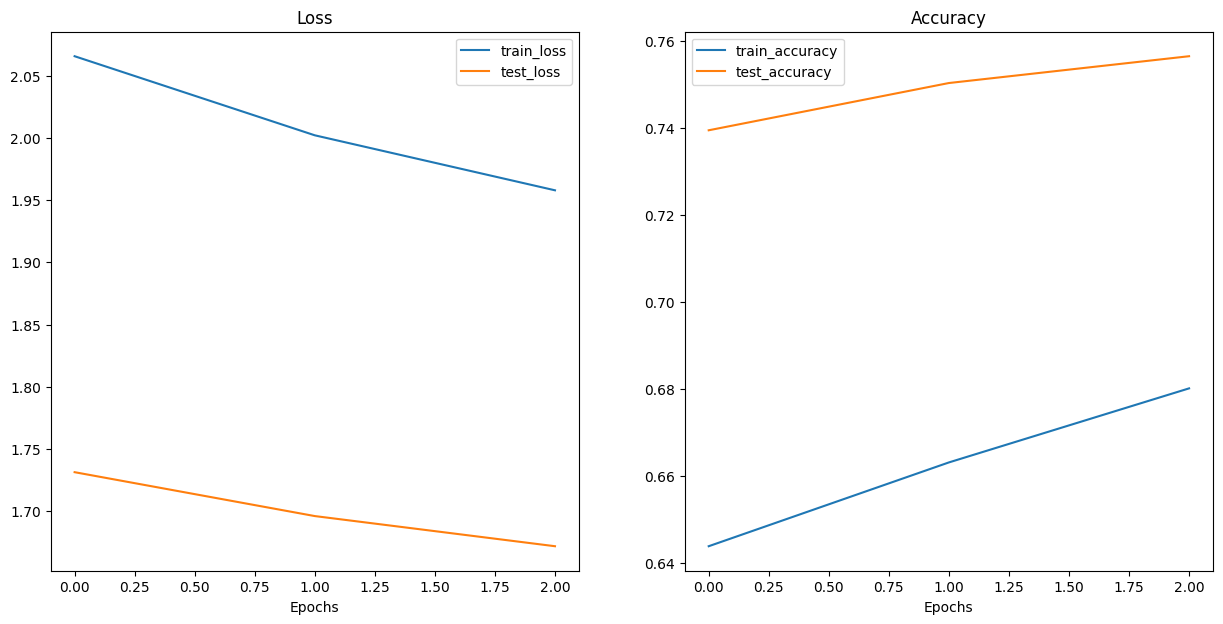

In [51]:
from helper_pytorch.helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(vit_result)

In [53]:
from helper_pytorch import utils

# Create a model path
vit_food101_model_path = "vit_model.pth"

# Save FoodVision Big model
utils.save_model(model=vit_model,
                 target_dir="models",
                 model_name=vit_food101_model_path)

[INFO] Saving model to: models/vit_model.pth


In [54]:
# Create Food101 compatible EffNetB2 instance
loaded_vit_food101, vit_transforms = create_vit_model(num_classes=101)

# Load the saved model's state_dict()
loaded_vit_food101.load_state_dict(torch.load("models/vit_model.pth"))

<All keys matched successfully>

In [55]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_food101_model_size = Path("models", vit_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_vit_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 327 MB


In [56]:
from pathlib import Path
food_visin_path = Path("demos/foodvison_big/")
food_visin_path.mkdir(parents=True,
                      exist_ok=True)
(food_visin_path/ "examples").mkdir(parents=True,
                                      exist_ok=True)

In [57]:
# Create path to Food101 class names
foodvision_big_class_names_path = food_visin_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvison_big/class_names.txt


In [58]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]

# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [ ]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [ ]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_vit_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
effnetb2, effnetb2_transforms = create_vit_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="vit_model.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision App"
description = "A vision transformer feature extractor computer vision model to classify images of food"

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

In [ ]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

In [ ]:
# # Zip foodvision_big folder but exclude certain files
# !cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# # Download the zipped FoodVision Big app (if running in Google Colab)
# try:
#     from google.colab import files
#     files.download("demos/foodvision_big.zip")
# except:
#     print("Not running in Google Colab, can't use google.colab.files.download()")